In [1]:
import pandas as pd
import numpy as np
import re
import nltk


### 1) EDA

In [2]:
df = pd.read_csv("dsets/WELFake_Dataset.csv")
print(df.info())
print("\n\nShape:",df.shape)
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72134 entries, 0 to 72133
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  72134 non-null  int64 
 1   title       71576 non-null  object
 2   text        72095 non-null  object
 3   label       72134 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 2.2+ MB
None


Shape: (72134, 4)


,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [3]:
df['label'].value_counts()

1    37106
0    35028
Name: label, dtype: int64

In [4]:
# check NA'set
print(df.isna().sum())

df = df.dropna()


print(df.isna().sum())
print("\n\nShape:",df.shape)

Unnamed: 0      0
title         558
text           39
label           0
dtype: int64
Unnamed: 0    0
title         0
text          0
label         0
dtype: int64


Shape: (71537, 4)


In [5]:
df.reset_index(drop=True, inplace=True)
df.head()

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
2,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
3,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1
4,5,About Time! Christian Group Sues Amazon and SP...,All we can say on this one is it s about time ...,1


In [6]:
df.columns

Index(['Unnamed: 0', 'title', 'text', 'label'], dtype='object')

In [7]:
df = df.drop(['Unnamed: 0','text'],axis = 1)
df.head()

,title,label
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,1
1,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,1
2,"Bobby Jindal, raised Hindu, uses story of Chri...",0
3,SATAN 2: Russia unvelis an image of its terrif...,1
4,About Time! Christian Group Sues Amazon and SP...,1


### 2) Preprocessing

In [8]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
print(len(stop_words))

def remove_stop_words(list_data):
    removed_words = []
    for word in list_data:
        if word not in stop_words:
            removed_words.append(word)

    return removed_words


179


Stemming

In [9]:
from nltk.stem import PorterStemmer

def get_stemmed_porter(list_data):
    porterStemmer = PorterStemmer()
    stemmed_words = []
    for word in list_data:
        stemmed_words.append(porterStemmer.stem(word))

    return stemmed_words

In [10]:
from nltk.stem import WordNetLemmatizer

def get_lemmatized_wnet(list_data,check_stopwords=False):
    wnet_lemmatizer = WordNetLemmatizer()
    lemmatized_words = []

    if check_stopwords:
        for word in list_data:
            if word not in stop_words:
                lemmatized_words.append(wnet_lemmatizer.lemmatize(word.lower()))

    if check_stopwords==False:
        for word in list_data:
            lemmatized_words.append(wnet_lemmatizer.lemmatize(word.lower()))

    return lemmatized_words



Create corpus

In [11]:
corpus_title = []
for title_i in df['title']:
    title_new = re.sub('^a-zA-Z',' ', title_i)
    title_new = title_new.split()
    title_new = get_lemmatized_wnet(title_new, check_stopwords=True)
    title_new = " ".join(title_new)
    corpus_title.append(title_new)

len(corpus_title)

71537

In [12]:
print(df['title'][0])
print(corpus_title[0])

LAW ENFORCEMENT ON HIGH ALERT Following Threats Against Cops And Whites On 9-11By #BlackLivesMatter And #FYF911 Terrorists [VIDEO]
law enforcement on high alert following threat against cop and white on 9-11by #blacklivesmatter and #fyf911 terrorist [video]


### 3) Vectorizers and Data Splitter

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle

tf_vectorizer = TfidfVectorizer(max_features=25000, 
                                min_df=2, 
                                max_df=0.8)

tf_obj = tf_vectorizer.fit(corpus_title)

pickle.dump(tf_obj, open('tf_obj.pkl','wb'))

In [14]:
X = tf_vectorizer.fit_transform(corpus_title)
X = X.toarray()

y = df["label"]

In [15]:
print(X.shape)

(71537, 18775)


In [16]:
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [17]:
y.head()

0    1
1    1
2    0
3    1
4    1
Name: label, dtype: int64

In [18]:
print(len(X))
print(len(y))

71537
71537


In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y, 
                                                    test_size = 0.25, 
                                                    random_state = 42, 
                                                    stratify = y)


print("Train len:",len(X_train),len(y_train))
print("Test len:",len(X_test),len(y_test))

Train len: 53652 53652
Test len: 17885 17885


In [20]:
print(X_train.shape)
print(X_test.shape)

(53652, 18775)
(17885, 18775)


### 4) Model Training

In [21]:
from sklearn.ensemble import RandomForestClassifier

rand_forest = RandomForestClassifier()
rand_forest.fit(X_train, y_train)

RandomForestClassifier()

In [22]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

y_pred = rand_forest.predict(X_test)

def calculate_metrics(y_test, y_pred):
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision :", precision_score(y_test, y_pred))
    print("Sensitivity (Recall):", recall_score(y_test, y_pred))
    print("Specificity:", recall_score(y_test, y_pred, pos_label=0))
    print("Specificity:", f1_score(y_test, y_pred))
    print()
    print(classification_report(y_test, y_pred))

calculate_metrics(y_test, y_pred)

Accuracy: 0.9316186748672072
Precision : 0.9167984814931983
Sensitivity (Recall): 0.9524539877300614
Specificity: 0.9099006509078451
Specificity: 0.9342861748428348

              precision    recall  f1-score   support

           0       0.95      0.91      0.93      8757
           1       0.92      0.95      0.93      9128

    accuracy                           0.93     17885
   macro avg       0.93      0.93      0.93     17885
weighted avg       0.93      0.93      0.93     17885



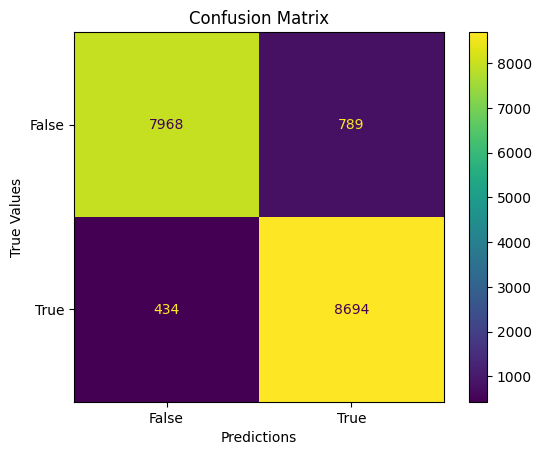

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(y_test, 
                               y_pred,
                               )

cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, 
                                    display_labels = [False, True])
                                    

cm_display.plot()
plt.xlabel("Predictions")
plt.ylabel("True Values")
plt.title("Confusion Matrix")
plt.show()

In [24]:
pickle.dump(tf_vectorizer,open('tfidf_vectorizer.pkl','wb'))
pickle.dump(rand_forest,open('rand_forest.pkl','wb'))

In [38]:
def make_single_pred(text, model, tf_vectorizer):
    processed_text = []
    for title_i in [text]:
        title_new = re.sub('^a-zA-Z',' ', title_i)
        title_new = title_new.split()
        title_new = get_lemmatized_wnet(title_new, check_stopwords=True)
        title_new = " ".join(title_new)
        processed_text.append(title_new)

    tokenized_text = tf_vectorizer.transform(processed_text)
    pred = model.predict(tokenized_text)[0]
    return pred

loaded_tf_obj= pickle.load(open('tf_obj.pkl', 'rb'))

make_single_pred("USA will sell 2000 F-35's to Turkey!", rand_forest, loaded_tf_obj)


0

In [37]:
make_single_pred("Schools will be open on Monday!", rand_forest, loaded_tf_obj)

1